<a href="https://colab.research.google.com/github/hfoffani/HF-fastai/blob/main/iula_blurr_fastai_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq transformers datasets tqdm
!pip install -Uqq ohmeow-blurr
!pip install -Uqq wandb

     |████████████████████████████████| 2.6 MB 4.0 MB/s 
     |████████████████████████████████| 264 kB 51.3 MB/s 
     |████████████████████████████████| 76 kB 4.5 MB/s 
     |████████████████████████████████| 3.3 MB 25.3 MB/s 
     |████████████████████████████████| 895 kB 50.8 MB/s 
     |████████████████████████████████| 636 kB 45.9 MB/s 
     |████████████████████████████████| 243 kB 51.1 MB/s 
     |████████████████████████████████| 118 kB 51.0 MB/s 
     |████████████████████████████████| 75 kB 2.5 MB/s 
     |████████████████████████████████| 188 kB 7.2 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.2 MB 7.9 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 170 kB 41.5 MB/s 
     |████████████████████████████████| 138 kB 42.5 MB/s 
     |██████████████████████

In [ ]:
import os
import glob
import pandas as pd

from transformers import AutoModelForSequenceClassification
from datasets import load_dataset

from blurr.utils import BLURR
from blurr.data.core import HF_TextBlock
from blurr.modeling.core import HF_BaseModelWrapper, HF_BaseModelCallback, hf_splitter

# import wandb

from fastai.text.all import *
from fastai.callback.wandb import *


### Leer Corpus

In [ ]:
co_df = pd.read_csv('/content/drive/MyDrive/iula-es.csv')
num_labels = co_df['label'].nunique()
co_df

,Unnamed: 0,label,sentence,is_valid
0,0,economia,LOS POSTULADOS DE LA ECONOMÍA CLÁSICA,True
1,1,economia,"La mayor parte de los tratados sobre la teoría del valor y de la producción se refieren, en primer término, a la distribución de un volumen dado de recursos empleados en diferentes usos, y a las condiciones que, supuesta la ocupación de esta cantidad de recursos, determinen su remuneración relativa y el relativo valor de sus productos [1]",False
2,2,economia,"También se ha sujetado con frecuencia a un procedimiento descriptivo lo relativo al monto de los recursos disponibles (entendiendo por tales el volumen de población susceptible de tomar empleo), los límites de la riqueza natural y el equipo de producción acumulado; pero rara vez se ha examinado detenidamente en la teoría pura, la explicación de lo que determina la ocupación real de los recursos disponibles.",False
3,3,economia,"Decir que no se ha considerado en absoluto, seria absurdo, por supuesto; porque todo estudio sobre los altibajos de la ocupación, que han sido muchos, ha tenido que ver con el tema.",False
4,4,economia,"No quiero decir que se haya pasado por alto, sino que la teoría fundamental en que descansa se ha creído tan sencilla y evidente que casi no había para qué mencionarla [2]",False
...,...,...,...,...
52350,52350,medicina,Diarrea.,True
52351,52351,medicina,Debilidad.,False
52352,52352,medicina,Gusto alterado.,False
52353,52353,medicina,Parestesias peribucales.,False


### Modelar

In [ ]:

# pretrained_model_name = "distilbert-base-uncased"
# pretrained_model_name = "bert-base-uncased"
# pretrained_model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
pretrained_model_name = "distilroberta-base"

In [ ]:
model_cls = AutoModelForSequenceClassification


hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(
    pretrained_model_name,
    model_cls=model_cls,
    config_kwargs={'num_labels': num_labels})

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/331M [00:00<?, ?B/s]

In [ ]:
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock)
dblock = DataBlock(blocks=blocks,
                   get_x=ColReader('sentence'),
                   get_y=ColReader('label'),
                   splitter=ColSplitter())

dls = dblock.dataloaders(co_df, bs=4, val_bs=8)

In [ ]:
dls.show_batch(dataloaders=dls)

,text,category
0,"En una economía estacionaria quizá no valiera la pena mencionar todo esto, ya que en cada año los márgenes de tolerancia para la depreciación, con respecto a las casas viejas, quedarían compensados exactamente por las casas nuevas que se construyeran en sustitución de las que llegan al fin de su vida cada año; pero tales factores pueden ser de mucha importancia en una economía no estática, especialmente durante el periodo que sigue de inmediato a un vigoroso brote de inversión de capital a largo plazo; porque en tales circunstancias gran parte de las nuevas partidas de inversión puede ser absorbida por las mayores reservas financieras que hacen los empresarios para reparar y renovar el equipo de producción existente, el cual, aunque se desgasta con el tiempo, todavía no ha llegado a la fecha en que deben hacerse gastos que puedan aproximarse al total de la reserva financiera que se aparta; con la consecuencia de que los ingresos no pueden subir por encima de un nivel lo bastante bajo para corresponder a un total pequeño de inversión neta.",economia
1,"Al incluir las emisiones del sector del transporte marítimo en la optimización para la meta intermedia de una reducción de distancias del 50%, se demostró que era conveniente desde el punto de vista de la relación coste/eficacia reducir las emisiones de SO2 desde buques en el mar Báltico y el mar del Norte, así como reducir las emisiones de óxidos de nitrógeno en el mar Báltico, el mar del Norte y algunas zonas del océano Atlántico.",ambiente
2,"Incluso algunos trastornos autosómicos dominantes bien establecidos pueden presentar a menudo un historial familiar negativo a causa de las elevadas proporciones de nuevas mutaciones [entre los ejemplos se incluyen el síndrome de Marfan, la neurofibromatosis de tipo 1 (NF1) y la acondroplasia, en los que las proporciones de casos provocados por nuevas mutaciones son del 30, 50, y 80 %, respectivamente].",medicina
3,"Este, por ejemplo, puede ser el tipo de URL que se va a encontrar más frecuentemente: http://edb518ea.edb.utexas.edu/html/LatinAmerica.html Más que ser un buen mecanógrafo, es necesario poseer ciertas dotes de memoria y una mano firme en el teclado para no equivocarse, porque de no ser así, recibiremos un mensaje como el que nos muestra la figura 7.6.",technologia


In [ ]:
b = dls.one_batch()

len(b), b[0]['input_ids'].shape, b[1].shape, dls.c

(2, torch.Size([4, 343]), torch.Size([4]), 5)

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn = Learner(dls, 
                model,
                opt_func=Adam,
                loss_func=CrossEntropyLossFlat(),
                metrics=[F1Score(average=None)],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)
learn = learn.to_fp16()
learn.freeze()


In [ ]:
learn.summary()

HF_BaseModelWrapper (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 343 x 768       
Embedding                                 38603520   False     
Embedding                                 394752     False     
Embedding                                 768        False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
            

### Entrenar

SuggestedLRs(valley=0.0004786300996784121)

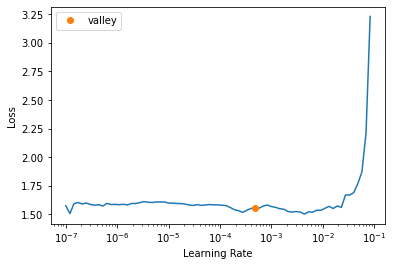

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, lr_max=1e-3)

epoch,train_loss,valid_loss,f1_score,time


KeyboardInterrupt: ignored

In [ ]:
learn.show_results(learner=learn, max_n=5)

,text,category,target
0,"Quedan reservadas, en todo caso, a las Fuerzas y Cuerpos de Seguridad del Estado bajo la dependencia del Gobierno los servicios policiales de carácter extracomunitario y supracomunitario como la vigilancia de puertos, aeropuertos, costas y fronteras, aduanas, control de entrada y salida del territorio nacional de españoles y extranjeros, régimen general de extranjería, extradición y expulsión, emigración e inmigración, pasaportes, documento nacional de identidad, trafico, armas y explosivos, resguardo fiscal del Estado, contrabando y fraude fiscal y las demás funciones que directamente les encomienda el artículo 104 de la Constitución [19] y las que les atribuya la Ley orgánica que lo desarrolle.",legal,medicina
1,"En el capítulo anterior hice ver que, bajo el sistema de laissez-faire nacional y el patrón oro internacional, que era el ortodoxo en la segunda mitad del siglo XIX, no había medio disponible de que pudiera echar mano el gobierno para mitigar la miseria económica en el interior, excepto el de la competencia por los mercados; porque se desechaban todas las medidas que pudieran ayudar a un estado de desocupación crónica o subocupación intermitente, excepto las que servían para mejorar la balanza comercial en las partidas relativas a mercancías y servicios.",economia,medicina
2,"Se planificó una estratificación retrospectiva para tener en cuenta los factores pronósticos basales (sexo, edad, estado general, pérdida de peso, presencia de metástasis hepáticas, localización primitiva del tumor, numero de localizaciones metastásicas, respuesta al tratamiento con fluorouracilo y duración de éste, así como su objetivo [adyuvante o paliativo], hemoglobina, recuento de leucocitos, plaquetas. lacticodeshidrogenasa, transaminasas, fosfatasa alcalina, bilirrubina, proteínas y antígeno carcinoembrionario).",medicina,medicina
3,"La base de la pérdida o retención cromosómica aún se desconoce; la característica importante de híbridos de células somáticas de roedor/humano es que los cromosomas de éste último, y no del roedor, son los que se pierden de manera preferente, lo cual provoca que las células híbridas conserven combinaciones y cifras diferentes de cromosomas humanos, como lo demuestran varias técnicas de cariotipificación que distinguen entre cromosomas de roedor y humanos (figuras 8-1 y 8-2).",medicina,medicina
4,"En países en los cuales la burocracia era un factor potente y, como en Alemania, se había adherido al liberalismo económico durante el período anterior, se produjo un cambio de importancia: sin pasar a posiciones precisamente hostiles, la burocracia empezó a contemplar de otro modo la clase patronal, a considerarla como algo que hay que controlar y dirigir, no dejar suelto; a contemplarla, pues, al modo como la percibe hoy la burocracia norteamericana.",economia,medicina


### Evaluar

In [ ]:
val_res = learn.validate()

val_res_d = { 'loss': val_res[0]}
for idx, m in enumerate(learn.metrics):
    val_res_d[m.name] = val_res[idx+1]
    
val_res_d

{'f1_score': array([0.       , 0.       , 0.       , 0.6754791, 0.       ]),
 'loss': 1.183095932006836}

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
print(preds.shape, targs.shape, losses.shape)
print(losses.mean(), accuracy(preds, targs))

torch.Size([10471, 5]) torch.Size([10471]) torch.Size([10471])
TensorBase(1.1831) TensorBase(0.5100)


### Infererir

In [ ]:
learn.export('iula_learner.pkl')

In [ ]:
inf_learn = load_learner('iula_learner.pkl')

In [ ]:
inf_learn.blurr_predict(pd.DataFrame([
    {'sentence': 'Según el BCE la inflación en el próximo año será menor al 2%'},
    {'sentence': 'La cardiopatía congénita es tratable vía transplante'},
]))

[(('medicina',),
  (#1) [tensor(3)],
  (#1) [tensor([0.0812, 0.0971, 0.0089, 0.5183, 0.2945])]),
 (('medicina',),
  (#1) [tensor(3)],
  (#1) [tensor([0.0812, 0.0971, 0.0089, 0.5183, 0.2945])])]